
# Solution

provo ad usare solo il label encoder per tutte le var

In [34]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [35]:
file_path = './data/rating_stats.csv'
df = pd.read_csv(file_path, delimiter=';')

# Controllo delle prime righe del dataset per visualizzare i dati
df.head()

,id,player_name,player_id,fixture_id,league_round,rating,event_datetime,team_name,position,home_or_away,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,1,A. Barák,8779,390,1,0.0,17/08/2024 18:30,Fiorentina,Midfielder,away,...,0,0,0,0,0,0,0,0,0,0.0
1,2,A. Barák,8779,392,2,7.3,25/08/2024 18:30,Fiorentina,Midfielder,home,...,0,0,0,0,0,0,0,0,0,5.5
2,3,A. Bastoni,8619,384,1,6.9,17/08/2024 18:30,Inter,Defender,away,...,1,1,0,0,0,0,0,0,0,6.5
3,4,A. Bastoni,8619,394,2,7.2,24/08/2024 20:45,Inter,Defender,home,...,0,1,0,0,0,0,0,0,0,6.5
4,5,A. Bastoni,8619,404,3,7.5,30/08/2024 20:45,Inter,Defender,home,...,1,1,0,0,0,0,0,0,0,6.5


In [36]:
print(df.columns)

Index(['id', 'player_name', 'player_id', 'fixture_id', 'league_round',
       'rating', 'event_datetime', 'team_name', 'position', 'home_or_away',
       'opponent_team', 'result', 'result_status', 'games_minutes',
       'games_substitute', 'offsides', 'shots_total', 'shots_on',
       'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
       'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
       'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
       'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
       'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
       'penalty_committed', 'penalty_scored', 'penalty_missed',
       'penalty_saved', 'rating_target'],
      dtype='object')


## Data Preparation

In [37]:
# Filtro colonne
columns_to_keep = [
    'rating', 'position', 'result_status', 'games_minutes',
    'games_substitute', 'offsides', 'shots_total', 'shots_on',
    'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves',
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total',
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn',
    'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won',
    'penalty_committed', 'penalty_scored', 'penalty_missed',
    'penalty_saved', 'rating_target'
]

# Filtrare il DataFrame mantenendo solo le colonne specificate
df_filtered = df[columns_to_keep]

df_filtered.head()

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
0,0.0,Midfielder,D,0,VERO,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5.5
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6.5
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5


In [38]:
# Filtro righe con games_minutes > 0
# in quanto non rilevanti perché il target sarà 0
# inoltre potrebbe aggiungere rumore al modello

df_filtered = df_filtered[df_filtered['games_minutes'] > 0]
df_filtered

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5.5
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6.5
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
6,7.0,Defender,L,82,FALSO,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,Attacker,D,71,FALSO,2,1,0,0,0,...,3,5,0,0,0,0,0,0,0,6.0
2244,6.9,Attacker,D,67,FALSO,1,1,0,0,0,...,1,3,0,0,0,0,0,0,0,6.0
2245,6.6,Attacker,L,90,FALSO,0,2,1,0,0,...,0,1,0,0,0,0,0,0,0,5.5
2246,6.9,Attacker,L,90,FALSO,0,1,0,0,0,...,2,4,0,0,0,0,0,0,0,5.5


### Encoding delle variabili categoriche

In [39]:
# One-Hot Encoding per position
#df_encoded = pd.get_dummies(df_filtered, columns=['position'], drop_first=False)
#df_encoded


In [40]:
# Ordinal Encoding per result_status
# perché ha un ordine intrinseco
#from sklearn.preprocessing import OrdinalEncoder

#ordinal_encoder = OrdinalEncoder(categories=[['L', 'D', 'W']])
#df_encoded['result_status_encoded'] = ordinal_encoder.fit_transform(df_encoded[['result_status']])
#df_encoded

In [61]:
# Label Encoding per games_substitute
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

df_encoded = df_filtered.copy()
df_encoded['games_substitute_encoded'] = le.fit_transform(df_encoded['games_substitute'].values.ravel())
df_encoded['result_status_encoded'] = le.fit_transform(df_encoded[['result_status']].values.ravel())
df_encoded['position_encoded'] = le.fit_transform(df_encoded[['position']].values.ravel())

df_encoded

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,games_substitute_encoded,result_status_encoded,position_encoded
1,7.3,Midfielder,D,55,FALSO,0,2,2,0,0,0,0,19,3,17,2,1,0.0,6,2,1,0,2,0,0,0,0,0,0,0,0,0,5.5,0,0,3
2,6.9,Defender,D,90,FALSO,0,0,0,0,0,0,0,72,2,65,2,0,0.0,8,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,0,1
3,7.2,Defender,W,90,FALSO,0,0,0,0,0,0,0,87,0,80,1,0,1.0,4,1,0,0,0,0,1,0,0,0,0,0,0,0,6.5,0,2,1
4,7.5,Defender,W,61,FALSO,0,0,0,0,0,0,0,47,0,44,2,0,1.0,6,5,0,0,0,1,1,0,0,0,0,0,0,0,6.5,0,2,1
6,7.0,Defender,L,82,FALSO,0,0,0,0,0,0,0,60,1,54,1,0,2.0,8,5,0,0,1,2,1,0,0,0,0,0,0,0,6.0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,6.6,Attacker,D,71,FALSO,2,1,0,0,0,0,0,7,1,5,0,0,0.0,11,5,1,1,0,3,5,0,0,0,0,0,0,0,6.0,0,0,0
2244,6.9,Attacker,D,67,FALSO,1,1,0,0,0,0,0,6,1,5,0,0,0.0,6,2,2,1,0,1,3,0,0,0,0,0,0,0,6.0,0,0,0
2245,6.6,Attacker,L,90,FALSO,0,2,1,0,0,0,0,24,1,20,0,0,0.0,12,4,8,3,1,0,1,0,0,0,0,0,0,0,5.5,0,1,0
2246,6.9,Attacker,L,90,FALSO,0,1,0,0,0,0,0,13,2,9,0,0,0.0,11,3,2,1,0,2,4,0,0,0,0,0,0,0,5.5,0,1,0


In [43]:
# rimuovo le colonne che non servono più
df = df_encoded.copy()

df['games_substitute'] = df['games_substitute_encoded'].astype(int)
df['result_status'] = df['result_status_encoded'].astype(int)
df['position'] = df['position_encoded'].astype(int)

df = df.drop('games_substitute_encoded', axis=1)
df = df.drop('result_status_encoded', axis=1)
df = df.drop('position_encoded', axis=1)

df.head()

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
1,7.3,3,0,55,0,0,2,2,0,0,...,0,0,0,0,0,0,0,0,0,5.5
2,6.9,1,0,90,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
3,7.2,1,2,90,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,6.5
4,7.5,1,2,61,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,6.5
6,7.0,1,1,82,0,0,0,0,0,0,...,2,1,0,0,0,0,0,0,0,6.0


### Robust Scaler
Normalizzazione dei dati. Uso Robust Scaler perché meno influenzato dagli outlier, inoltre, mantiene la distribuzione originale dei dati

In [44]:
from sklearn.preprocessing import RobustScaler

numerical_columns = [
    'rating', 'games_minutes', 'offsides', 'shots_total', 'shots_on', 
    'goals_total', 'goals_conceded', 'goals_assists', 'goals_saves', 
    'passes_total', 'passes_key', 'passes_accuracy', 'tackles_total', 
    'tackles_blocks', 'tackles_interceptions', 'duels_total', 'duels_won',
    'dribbles_attempts', 'dribbles_success', 'dribbles_past', 'fouls_drawn', 
    'fouls_committed', 'cards_yellow', 'cards_red', 'penalty_won', 
    'penalty_committed', 'penalty_scored', 'penalty_missed', 'penalty_saved',
    'games_substitute', 'result_status', 'position'
    #'rating_target'
]

data_scaler = RobustScaler()
df[numerical_columns] = data_scaler.fit_transform(df[numerical_columns])

target_scaler = RobustScaler()
df['rating_target'] = target_scaler.fit_transform(df[['rating_target']])


df.head()

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target
1,0.666667,0.666667,-0.5,-0.379310,0.0,0.0,2.0,2.0,0.0,0.0,...,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.5
2,0.000000,0.000000,-0.5,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
3,0.500000,0.000000,0.5,0.224138,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
4,1.000000,0.000000,0.5,-0.275862,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
6,0.166667,0.000000,0.0,0.086207,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Salvataggio dello scaler per uso successivo nella fase di post-processing

#caler_filename = './scalers/robust_scaler.pkl'
#import joblib
#joblib.dump(scaler, scaler_filename)

## Suddivisione in train/test e allenamento del modello LightGBM


In [48]:
X = df.drop('rating_target', axis=1)
y = df['rating_target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definizione del modello LightGBM con i parametri ottimizzati
lgb_model = lgb.LGBMRegressor(
    learning_rate=0.01,
    max_depth=20,
    n_estimators=500,
    num_leaves=50,
    lambda_l1=0.1,  # ridurre il valore per limitare la regolarizzazione L1
    lambda_l2=0.1   # ridurre il valore per limitare la regolarizzazione L2
)

# Allenamento del modello
lgb_model.fit(X_train, y_train)

# Previsione sui dati di test
y_pred = lgb_model.predict(X_test)

#  performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.4f}, R²: {r2:.4f}')

[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 401
[LightGBM] [Info] Number of data points in the train set: 1228, number of used features: 26
[LightGBM] [Info] Start training from score -0.425081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

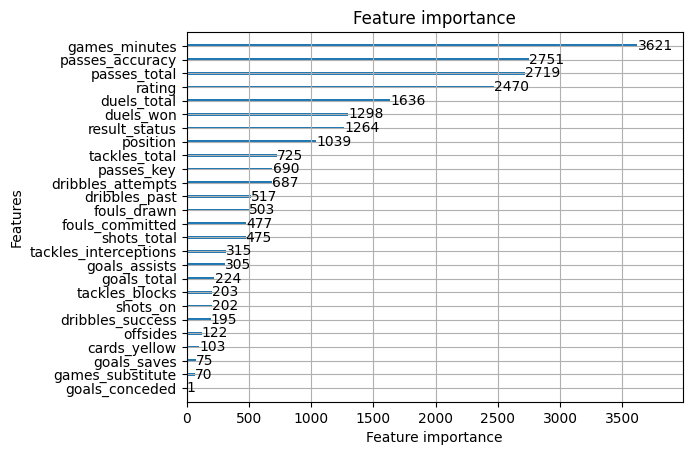

In [49]:
import matplotlib.pyplot as plt
lgb.plot_importance(lgb_model, max_num_features=50)
plt.show()

In [50]:
# 1. Inverso dello scaling per 'rating_target' su y_test e y_pred
y_test_original = target_scaler.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


y_pred_original = target_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Valutazione delle performance del modello
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f'RMSE (rating originale): {rmse:.4f}')
print(f'R² (rating originale): {r2:.4f}')

RMSE (rating originale): 1.0220
R² (rating originale): 0.6924


In [51]:
print("y_test_original | y_pred_original")
print("------------------------------")
for y_test, y_pred in zip(y_test_original, y_pred_original):
    print(f"{y_test:<15} | {y_pred:<15}")

y_test_original | y_pred_original
------------------------------
6.5             | 6.1549226455415065
6.5             | 6.547800155992894
5.5             | 5.387421911140874
0.0             | 2.439531524066977
6.5             | 6.334951021489465
7.0             | 6.808476736445682
5.0             | 5.418789943427965
6.5             | 5.2517718188102975
0.0             | 0.015294163487038048
5.5             | 5.360335847206884
5.5             | 6.082334127700124
5.5             | 5.315540846650865
7.0             | 6.83675109366626
0.0             | 4.070644689790051
7.0             | 6.758910482096791
6.0             | 5.405676625693138
5.5             | 5.772977950079104
6.0             | 5.598980909257294
6.0             | 5.840333900860128
5.5             | 6.211433760847194
5.5             | 5.873236893250977
7.5             | 6.890287398877099
0.0             | 1.6204804264660586
6.0             | 2.4788714354819215
6.0             | 5.887163720811559
0.0             | 5.770874833

In [52]:
# Recupera il dataset filtrato basato sugli indici di X_test (il dataset `df_filtered`)
X_test_filtered = df_filtered.loc[X_test.index, :].copy()

# Aggiungi le colonne del 'rating_target' originale e predetto al dataset filtrato
X_test_filtered['rating_target_original'] = y_test_original  # Valori originali del target
X_test_filtered['rating_target_predicted'] = y_pred_original  # Valori predetti (non arrotondati)

significant_columns = ['goals_total', 'goals_assists', 'penalty_scored', 'penalty_saved', 
                       'penalty_missed', 'penalty_committed', 'penalty_won', 'cards_red', 'cards_yellow']

non_significant_columns = [col for col in X_test_filtered.columns if col not in significant_columns + ['position', 'result_status', 'games_substitute', 'games_minutes', 'rating_target_original', 'rating_target_predicted']]


# Aggiungi la logica per sottrarre 0.85 se le colonne significative sono > 0, altrimenti 0 se le colonne non significative danno una somma < 20
X_test_filtered['rating_target_predicted'] = np.where(
    (X_test_filtered['games_minutes'] < 20) & (X_test_filtered['rating_target_predicted'] < 5),
    np.where(
        (X_test_filtered[significant_columns] > 0).any(axis=1) & (X_test_filtered[non_significant_columns].sum(axis=1) >= 20),  # Controlla le colonne significative e la somma delle non significative
        X_test_filtered['rating_target_predicted'] - 0.85,  # Sottrai 0.85
        0  # Assegna 0 se le condizioni non sono soddisfatte
    ),
    X_test_filtered['rating_target_predicted']  # Mantieni il valore arrotondato originale se la condizione non si applica
)

# Arrotondamento al mezzo punto più vicino per i valori predetti
X_test_filtered['rating_target_predicted'] = np.round(X_test_filtered['rating_target_predicted'] * 2) / 2

# Se vuoi salvare il dataset ricostruito su file CSV per ulteriori analisi
X_test_filtered.to_csv('./out/rating_predictions2.csv', index=False)

# Stampa del dataset ricostruito
X_test_filtered.head(20)

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,...,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,rating_target_original,rating_target_predicted
1726,6.9,Defender,W,90,FALSO,0,0,0,0,0,...,0,0,0,0,0,0,0,6.5,6.5,6.0
118,7.2,Defender,D,86,FALSO,0,0,0,0,0,...,0,0,0,0,0,0,0,6.5,6.5,6.5
494,6.3,Midfielder,L,64,FALSO,0,0,0,0,0,...,0,0,0,0,0,0,0,5.5,5.5,5.5
1548,7.0,Attacker,W,11,VERO,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
2011,7.0,Defender,W,62,FALSO,0,0,0,0,0,...,0,0,0,0,0,0,0,6.5,6.5,6.5
1386,7.3,Defender,W,90,FALSO,0,1,1,1,0,...,0,0,0,0,0,0,0,7.0,7.0,7.0
1153,6.6,Attacker,D,58,FALSO,0,1,0,0,0,...,0,0,0,0,0,0,0,5.0,5.0,5.5
2210,7.2,Defender,L,90,FALSO,0,1,1,0,0,...,0,0,0,0,0,0,0,6.5,6.5,5.5
1447,6.6,Attacker,L,9,VERO,0,0,0,0,0,...,0,0,0,0,0,0,0,0.0,0.0,0.0
1777,6.9,Defender,L,90,FALSO,0,0,0,0,0,...,1,0,0,0,0,0,0,5.5,5.5,5.5


In [53]:
df = X_test_filtered.copy()

# differenza tra rating target e rating_target_predicted
df['rating_diff'] = df['rating_target'] - df['rating_target_predicted']

pd.set_option('display.max_columns', None)
df[(abs(df['rating_diff']) > 1)].head(50)

,rating,position,result_status,games_minutes,games_substitute,offsides,shots_total,shots_on,goals_total,goals_conceded,goals_assists,goals_saves,passes_total,passes_key,passes_accuracy,tackles_total,tackles_blocks,tackles_interceptions,duels_total,duels_won,dribbles_attempts,dribbles_success,dribbles_past,fouls_drawn,fouls_committed,cards_yellow,cards_red,penalty_won,penalty_committed,penalty_scored,penalty_missed,penalty_saved,rating_target,rating_target_original,rating_target_predicted,rating_diff
584,7.2,Midfielder,W,11,VERO,0,1,1,0,0,0,0,14,0,14,2,0,0.0,6,4,2,2,1,0,0,0,0,0,0,0,0,0,6.0,6.0,0.0,6.0
111,6.3,Attacker,L,18,VERO,0,0,0,0,0,0,0,2,0,1,0,0,0.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.0,-6.0
78,6.3,Defender,W,13,VERO,0,0,0,0,0,0,0,9,0,7,0,0,0.0,2,1,1,0,0,0,0,0,0,0,0,0,0,0,6.0,6.0,0.0,6.0
470,6.3,Defender,D,12,VERO,0,0,0,0,0,0,0,3,0,1,0,0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,6.0,6.0,0.0,6.0
705,7.3,Midfielder,L,14,VERO,0,0,0,0,0,0,0,5,0,5,0,0,0.0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0.0,0.0,5.0,-5.0
1648,6.3,Attacker,W,12,VERO,0,2,1,0,0,0,0,4,0,2,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,5.5,5.5,0.0,5.5
1745,6.3,Defender,W,13,VERO,0,0,0,0,0,0,0,8,0,7,0,0,0.0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,6.0,6.0,0.0,6.0
2092,6.3,Defender,W,18,VERO,0,0,0,0,0,0,0,2,0,1,0,0,0.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,6.0,-6.0
24,7.3,Attacker,D,90,FALSO,1,3,2,0,0,0,0,21,3,17,0,0,0.0,14,3,3,1,0,1,2,0,0,0,0,0,0,0,5.0,5.0,6.5,-1.5
1232,6.7,Midfielder,L,63,FALSO,0,1,0,0,0,0,0,42,1,40,0,1,1.0,3,1,0,0,1,0,1,0,0,0,1,0,0,0,4.0,4.0,5.5,-1.5


In [73]:
# Perc di record con rating_diff > 1
print("% rec con rating_diff > 1: ", len(df[(abs(df['rating_diff']) > 1)]) / len(df) * 100)

# Perc di record con rating_diff >= 1
print("% rec con rating_diff >= 1: ", len(df[(abs(df['rating_diff']) >= 1)]) / len(df) * 100)


% rec con rating_diff > 1:  4.545454545454546
% rec con rating_diff >= 1:  12.987012987012985


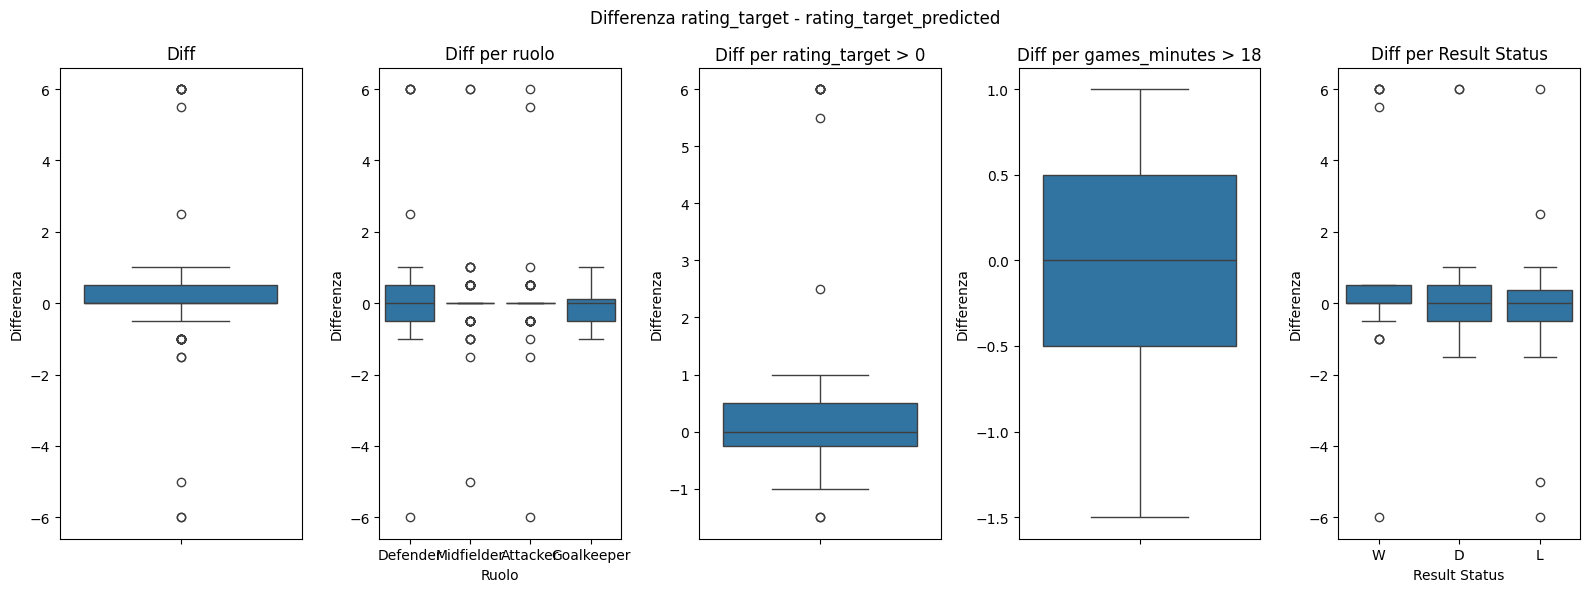

In [55]:
# Stats di base sulla differenza tra rating e rating target
diff_overall = df['rating_diff'].describe()

# 2. Statistiche di base sulla differenza, raggruppata per ruolo (position)
diff_by_position = df.groupby('position')['rating_diff'].describe()

# 3. Filtrare righe con rating_target > 0
filtered_df = df[(df['rating_target'] > 0)]
diff_filtered = filtered_df['rating_diff'].describe()

# Impostazioni per i grafici
plt.figure(figsize=(16, 6))
plt.suptitle("Differenza rating_target - rating_target_predicted")

# 1. Boxplot della differenza complessiva tra rating_target e rating
plt.subplot(1, 5, 1)
sns.boxplot(y=df['rating_diff'])
plt.title('Diff')
plt.ylabel('Differenza')

# 2. Boxplot della differenza per ruolo (position)
plt.subplot(1, 5, 2)
sns.boxplot(x=df['position'], y=df['rating_diff'])
plt.title('Diff per ruolo')
plt.xlabel('Ruolo')
plt.ylabel('Differenza')

# 3. Boxplot delle righe filtrate con rating_target > 0
filtered_df = df[df['rating_target'] > 0]
plt.subplot(1, 5, 3)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Diff per rating_target > 0')
plt.ylabel('Differenza')

# 3. Boxplot delle righe filtrate con rating_target > 0
filtered_df = df[df['games_minutes'] > 18]
plt.subplot(1, 5, 4)
sns.boxplot(y=filtered_df['rating_diff'])
plt.title('Diff per games_minutes > 18')
plt.ylabel('Differenza')

# 4. Boxplot della differenza rispetto a result_status
plt.subplot(1, 5, 5)
sns.boxplot(x=df['result_status'], y=df['rating_diff'])
plt.title('Diff per Result Status')
plt.xlabel('Result Status')
plt.ylabel('Differenza')

plt.tight_layout()
plt.show()

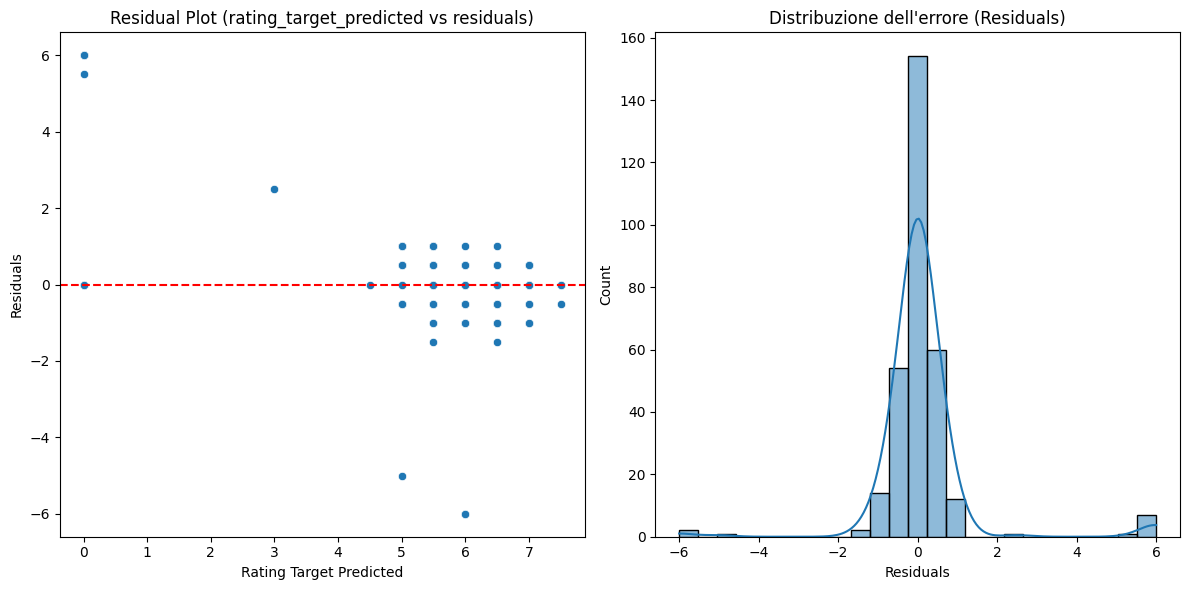

In [58]:
# 1. Residual Plot (Grafico dei residui)
plt.figure(figsize=(12, 6))

# Calcolare i residui (errore)
df['residuals'] = df['rating_target'] - df['rating_target_predicted']

# Residual plot: rating_target vs residui
plt.subplot(1, 2, 1)
sns.scatterplot(x=df['rating_target_predicted'], y=df['residuals'])
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual Plot (rating_target_predicted vs residuals)')
plt.xlabel('Rating Target Predicted')
plt.ylabel('Residuals')

# 2. Distribuzione dell'errore
plt.subplot(1, 2, 2)
sns.histplot(df['residuals'], kde=True, bins=25)
plt.title('Distribuzione dell\'errore (Residuals)')
plt.xlabel('Residuals')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [59]:
# Errore medio assoluto (MAE)
mae = np.mean(np.abs(df['residuals']))
print(f'Mean Absolute Error (MAE): {mae:.2f}')

# Calcola l'RMSE
rmse = root_mean_squared_error(df['rating_target'], df['rating_target_predicted'])

print("RMSE:", rmse)

Mean Absolute Error (MAE): 0.50
RMSE: 1.201325026036592
